In [1]:
import pandas as pd

ddir = "universe_8/"
data = pd.read_csv(ddir + 'combined_stars.csv')

X = data['X'] 
Y = data['Y']     
parallax = data['Parallax']    

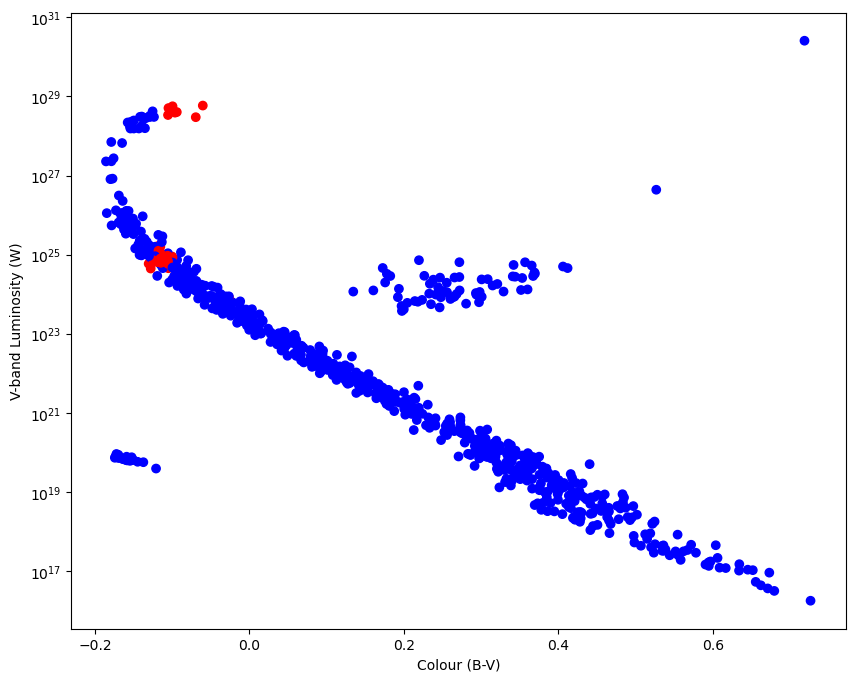

In [2]:
import numpy as np
import matplotlib.pyplot as plt

localindex = [i for i, x in enumerate(parallax) if x > 0.007]
localVflux = np.array(data["GreenF"])[localindex]
localBflux = np.array(data["BlueF"])[localindex]
BV = np.log10(localVflux / localBflux) # B-V colour index 

localVlumin = localVflux * (1 / np.array(data["Parallax"][localindex]) * 3.086 * 10**16)**2

localvariables = data["Variable?"][localindex]
colours = ['r' if var==1 else 'b' for var in localvariables] # this means variable stars are red, normal stars are blue

fig = plt.figure(figsize=(10, 8))   # make a figure to plot stuff on
ax = fig.add_subplot(1, 1, 1)    # and add an axis so we can plot stuff on the figure
ax.scatter(BV, localVlumin, c=colours)
ax.set_yscale('log'); ax.set_xlabel('Colour (B-V)'); ax.set_ylabel('V-band Luminosity (W)');

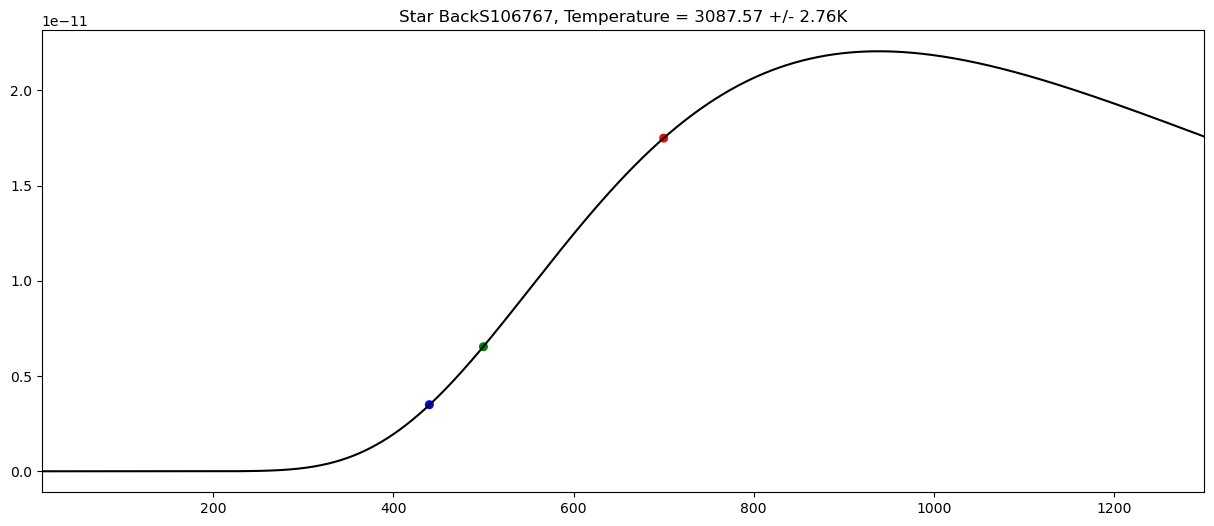

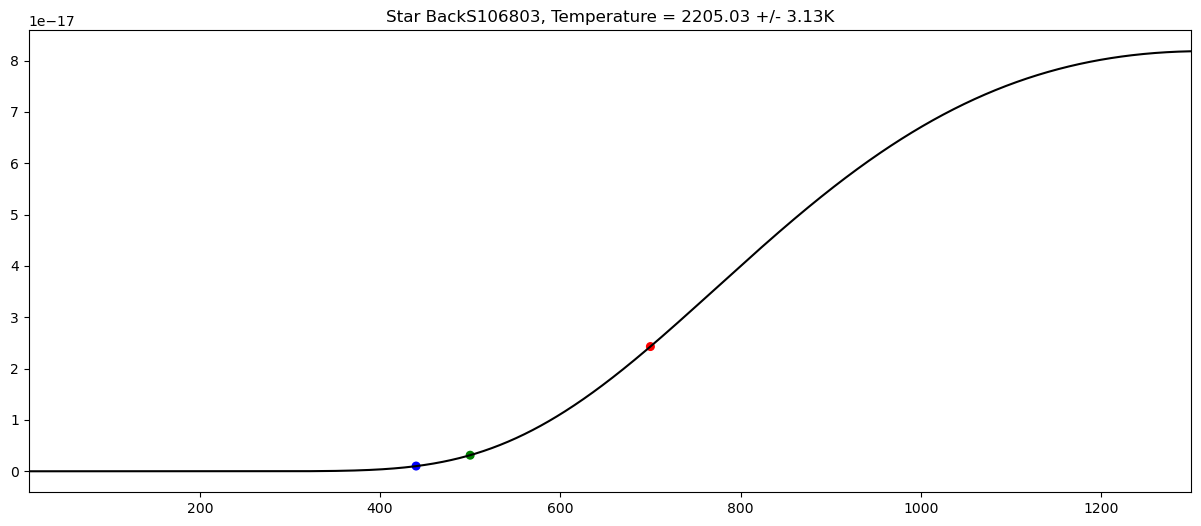

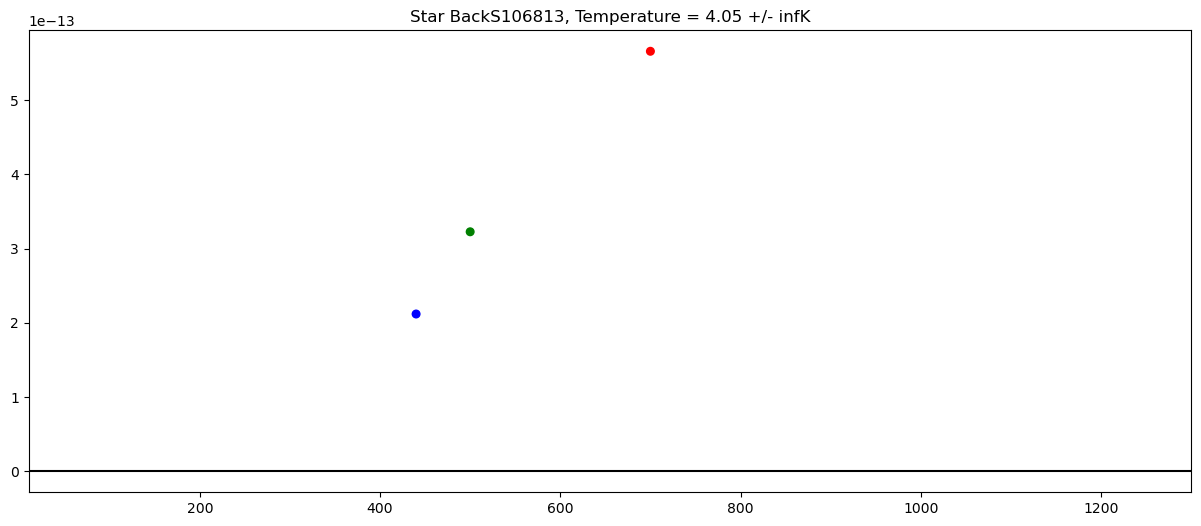

In [3]:
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')  

def planck_func(x, T, a):
    const1 = 4.702 * 10**(-15)         #corresponds to 8 pi^2 * h * c^2
    const2 = 0.01439              #corresponds to h * c / k 
    funct = a * (const1 / (x * 10**-9)**5) * (1 / (np.exp(const2 / (x * 10**-9 * T)) - 1))
    return funct

# get the indices of stars in the local galaxy
closeindexes = [i for i, x in enumerate(parallax) if x > 0.007]

# now isolate each spectral band for each star
starBlue = data['BlueF']; starBlue = [starBlue[i] for i in closeindexes]
starGreen = data['GreenF']; starGreen = [starGreen[i] for i in closeindexes]
starRed = data['RedF']; starRed = [starRed[i] for i in closeindexes]
starnames = data["Name"]; starnames = [starnames[i] for i in closeindexes]

b, g, r = 440, 500, 700        #corresponding wavelengths for each luminosity measurement
wavelengths = np.array([b, g, r])
colours = ["b", "g", "r"]

localtemps = np.zeros(len(starBlue))

for i in range(len(starBlue)):
    fluxes = np.array([starBlue[i], starGreen[i], starRed[i]])
    
    starProps, params = curve_fit(planck_func, wavelengths, fluxes, p0=[10000, 1 * 10**-28], maxfev=10000)
    starTemp, mult = starProps
    localtemps[i] = starTemp
    
    # the curve_fit function gives a covariance matrix, where the square root of the top left element shows us the
    # uncertainty in our temperature measurement
    uncertainty = np.sqrt(np.diag(params))[0]
    
    x = np.linspace(10, 1300, 1000)
    planck = mult * (4.702 * 10**(-15) / (x * 10**-9)**5) * (1 / (np.exp(0.01439 / (x * 10**-9 * starTemp)) - 1))
    if i in [3, 4, 5]:    # I chose 3, 4, and 5 since they were nice and different curves
        # now to plot these blackbody curves
        fig = plt.figure(figsize=(15, 6))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(x, planck, c='k', linewidth=1.5)
        ax.scatter(wavelengths, fluxes, c=colours, s=30)
        ax.set_xlim([min(x), max(x)])
        ax.set_title('Star %s, Temperature = %.2f +/- %.2fK'%(starnames[i], starTemp, uncertainty))

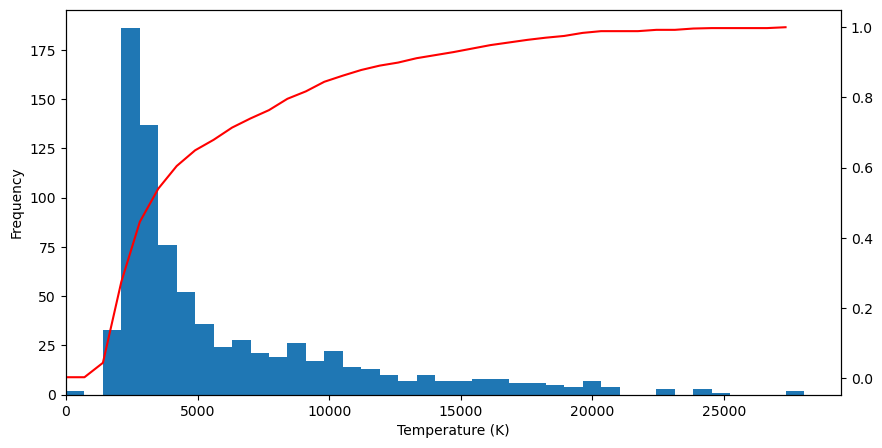

In [6]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
data = ax.hist(localtemps, bins=40)
ax.set_xlabel('Temperature (K)'); ax.set_ylabel('Frequency'); ax.set_xlim(xmin=0)

# lets also include a cumulative trendline
yvals, xbins, _ = data
cumulative = np.cumsum(yvals)
proportion = cumulative / sum(yvals)
ax2 = ax.twinx()
ax2.plot(xbins[:-1], proportion, 'r-')
